In [1]:
import os
import sys

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("PROJECT_ROOT:", PROJECT_ROOT)


PROJECT_ROOT: c:\Users\gehra\Documents\GitHub\Quant_coding


In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from src.data_loading import download_daily_prices, load_daily_close
from src.signals import make_basic_signals, build_feature_matrix, DEFAULT_FEATURES
from src.models_tree import train_tree_regressor, evaluate_regression
from src.backtest import (
    equity_curve_from_returns,
    cagr,
    annualized_vol,
    sharpe_ratio,
    max_drawdown,
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
ticker = "SPY"

# 1) Load or download prices
try:
    prices = load_daily_close(ticker)
except FileNotFoundError:
    download_daily_prices(ticker, start="2010-01-01")
    prices = load_daily_close(ticker)

# 2) Build signals + target
signals_df = make_basic_signals(prices)

signals_df.head(), signals_df.columns


c:\Users\gehra\Documents\GitHub\Quant_coding\src\data_loading.py:52: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_path, parse_dates=[0], index_col=0)


(                price     ret_1     ret_5    ret_10    vol_10    vol_20  \
 date                                                                      
 2010-03-16  87.596893  0.007966  0.017037  0.037523  0.004485  0.005395   
 2010-03-17  88.116074  0.005927  0.018527  0.042743  0.004417  0.005422   
 2010-03-18  88.070892 -0.000513  0.013772  0.039062  0.004657  0.005433   
 2010-03-19  87.625145 -0.005061  0.008554  0.019235  0.003771  0.005704   
 2010-03-22  88.093597  0.005346  0.013682  0.024504  0.003860  0.005718   
 
             ma10_rel  ma50_rel  target_ret_1  
 date                                          
 2010-03-16 -0.015807 -0.041416      0.005927  
 2010-03-17 -0.017506 -0.046420     -0.000513  
 2010-03-18 -0.013243 -0.045348     -0.005061  
 2010-03-19 -0.006336 -0.040022      0.005346  
 2010-03-22 -0.009228 -0.044635      0.007033  ,
 Index(['price', 'ret_1', 'ret_5', 'ret_10', 'vol_10', 'vol_20', 'ma10_rel',
        'ma50_rel', 'target_ret_1'],
       dtype='o

In [5]:
# Choose which signals you want to use
feature_names = DEFAULT_FEATURES  # or a custom list

X, y, dates = build_feature_matrix(signals_df, feature_names)

# Time-based split: 70% train, 30% test
split_idx = int(len(X) * 0.7)

X_train, y_train = X[:split_idx], y[:split_idx]
X_test, y_test = X[split_idx:], y[split_idx:]
dates_train, dates_test = dates[:split_idx], dates[split_idx:]

len(X_train), len(X_test), dates_train[0], dates_test[0]


(2769, 1188, '2010-03-16', '2021-03-16')

In [6]:
model = train_tree_regressor(X_train, y_train)
reg_metrics = evaluate_regression(model, X_test, y_test)
print("Test MSE:", reg_metrics["mse"])
preds = reg_metrics["preds"]


Test MSE: 0.00012079135215676687


In [7]:
# Long-only: 1 if predicted next-day return > 0, else 0 (in cash)
positions = (preds > 0).astype(int)

# Strategy returns = position * realised next-day return
strat_returns = positions * y_test

# Buy & hold = always fully invested -> same as y_test
bh_returns = y_test

# Put returns into Series with date index for nicer handling
bh_returns = np.asarray(bh_returns)
strat_returns = np.asarray(strat_returns)

bh_series = signals_df["target_ret_1"].iloc[split_idx:].copy()
bh_series[:] = bh_returns  # just to ensure same shape/index
strat_series = bh_series.copy()
strat_series[:] = strat_returns


In [8]:
equity_bh = equity_curve_from_returns(bh_series)
equity_strat = equity_curve_from_returns(strat_series)

metrics = {
    "bh_cagr": cagr(equity_bh),
    "bh_vol": annualized_vol(bh_series),
    "bh_sharpe": sharpe_ratio(bh_series),
    "bh_max_dd": max_drawdown(equity_bh),

    "strat_cagr": cagr(equity_strat),
    "strat_vol": annualized_vol(strat_series),
    "strat_sharpe": sharpe_ratio(strat_series),
    "strat_max_dd": max_drawdown(equity_strat),
}
metrics


{'bh_cagr': 0.13855462207540392,
 'bh_vol': np.float64(0.17240447363022696),
 'bh_sharpe': np.float64(0.9070226982470713),
 'bh_max_dd': -0.24496386521976077,
 'strat_cagr': 0.14850972113438332,
 'strat_vol': np.float64(0.14376227565917804),
 'strat_sharpe': np.float64(1.1211684316081443),
 'strat_max_dd': -0.18031106287368526}

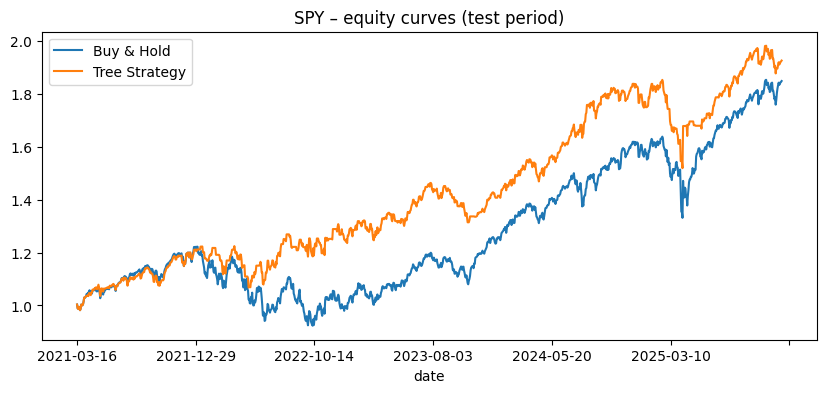

In [9]:
plt.figure(figsize=(10, 4))
equity_bh.plot(label="Buy & Hold")
equity_strat.plot(label="Tree Strategy")
plt.legend()
plt.title(f"{ticker} – equity curves (test period)")
plt.show()
